# Termoelasticidad lineal parte 2

Nota: a este documento no lo podremos ejecutar de manera dinámica con Binder, sólo lo podrán correr si tienen instalado:

- Python 3.5 o más nuevo instalado.
- [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html).
- [FEniCS](https://fenicsproject.org/).

### Referencias

- También sacamos el ejemplo del siguiente [enlace](https://comet-fenics.readthedocs.io/) desarrollado por  Jeremy Bleyer.

## Termoelasticidad lineal: modelo elástico estático totalmente acoplado

En este tutorial trabajaremos con el problema termoelástico en un enfoque totalmente acoplado, es decir, resolveremos al mismo tiempo ambas formulaciones variacionales: la referida al problema térmico y al problema mecánico elástico (estático en este caso). Pondremos el foco en cómo FEniCS resuelve el problema de computar FEM en problemas de **Funciones de espacio mixtas (Mixed FunctionSpace)**, esto es necesario porque utilizaremos dos espacios: uno escalar para la temperatura y uno vectorial para el desplazamiento.

Seguiremos considerando el caso de deformación *isotrópica* y en estado *estacionario*, es decir, la deformación es igual en las tres direcciones y esperamos suficiente tiempo a una determinada temperatura. La diferencia con el tutorial anterior es que ahora resolveremos (al mismo tiempo ambos problemas) la ecuación de evolución de calor completa, en efecto, computaremos el transitorio tal como lo hicimos en el [tutorial en que la presentamos](https://github.com/rirastorza/Intro2FEM/blob/master/Problemas_dependientes_del_tiempo/Introduccion_problema_termico.ipynb). Utilizaremos el *Método de Euler hacia atrás*, porque ya sabemos que es un problema dependiente del tiempo.

### Funciones de espacio mixtas

Como mencionamos, sabemos que tenemos que obtener el campo escalar de temperatura ($T$) y vectorial de desplazamientos ($u$). A la temperatura la expresaremos como diferencia de la temperatura inicial (siguiendo la notación de Bleyer): $\Theta = T -T_{0}$. Utilizaremos como temperatura de referencia $T_{0}=293 K$.

In [6]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt


L, H = 5, 0.3

mesh = RectangleMesh(Point(0., 0.), Point(L, H), 100, 10, "crossed")

T0 = Constant(293.)
DeltaT = Constant(10.)
E = 70e3
nu = 0.3
lmbda = Constant(E*nu/((1+nu)*(1-2*nu)))
mu = Constant(E/2/(1+nu))
rho = Constant(2700.)     # Densidad
alpha = 2.31e-5  # Coeficiente de expansión térmica
kappa = Constant(alpha*(2*mu + 3*lmbda))
cV = Constant(910e-6)*rho  # Calor específico por unidad de volumen a deformación constante.
k = Constant(237e-6)  # Conductividad térmica

rho_g = 10e-3
b = Constant((0, -rho_g))

Aquí remarcamos como se puede definir el espacio mixto. La notación *Vue$*$Vte* puede escribirse explícitando que es un espacio mixto de la siguiente manera:  *MixedElement([Vue, Vte])*. Se pueden encontrar varios ejemplos de este tipo de problemas en FEniCS como el de la Ec. de Poisson resolviendo el flujo de calor y la temperatura al mismo tiempo (ver el siguiente [tutorial](https://fenicsproject.org/docs/dolfin/2019.1.0/python/demos/mixed-poisson/demo_mixed-poisson.py.html)).

In [7]:
Vue = VectorElement('CG', mesh.ufl_cell(), 2) # elementos para el desplazamiento
Vte = FiniteElement('CG', mesh.ufl_cell(), 1) # elmentos para la temperatura
V = FunctionSpace(mesh, Vue*Vte)

El ejemplo que seguiremos es el mismo problema que vimos en el tutorial anterior. Definimos entonces las condiciones de borde:

In [8]:
def laterales(x, on_boundary):
    return (near(x[0], 0) or near(x[0], L)) and on_boundary
def abajo(x, on_boundary):
    return near(x[1], 0) and on_boundary
def arriba(x, on_boundary):
    return near(x[1], H) and on_boundary

bc1 = DirichletBC(V.sub(0), Constant((0., 0.)), laterales)
bc2 = DirichletBC(V.sub(1), Constant(0.), arriba)
bc3 = DirichletBC(V.sub(1), DeltaT, abajo)
bc4 = DirichletBC(V.sub(1), Constant(0.), laterales)
bcs = [bc1, bc2, bc3, bc4]

Noten que hemos definido con *V.sub(0)* las condiciones de borde mecánicas (los laterales empotrados) y con *V.sub(1)* las condiciones de borde térmicas (abajo el $\Delta T=10 K$ y en los laterales y arriba $\Delta T=0 K$).

### Formulación variacional

Ahora comentaremos la *formulación fuerte* primero y luego *la débil*. Consideramos la ley de Hooke con el término del problema térmico:

$$\sigma = 2\mu\varepsilon+\lambda tr\left(\varepsilon \right)  I -\alpha \left(3\lambda+ 2\mu\right)\left(T-T_{0}\right)I \tag{1}$$

Para modelar el problema mecánico estático utilizamos las ecuaciones ya conocidas:

$$\nabla \cdot \sigma + b = 0 \tag{2}$$

$$\varepsilon = \frac{1}{2}\left(\nabla u + \nabla u^{T}\right)\tag{3}$$

$b$ es la fuerza debido al peso de la pieza (body force).

Según la termodinámica (no pude encontrar una referencia clara de donde sacar esta ecuación) podemos expresar lo siguiente:

$$\rho s = \rho s_{0} + \frac{\rho C_{\varepsilon}}{T_{0}}\left(T-T_{0}\right)+\alpha \left(3\lambda+2\mu\right)tr\left(\varepsilon\right) \tag{4}$$

aquí $s$ es la entropía por unidad de masa en el estado actual respecto de una configuración inicial ($s_{0}$). $C_{\varepsilon}$ es el calor específico a deformación constante. El resto de los parámetros los conocemos del tutorial anterior.

El problema térmico si no consideramos una fuente de calor, se puede escribir de la siguente manera:

$$\rho T_{0}\dot{s}+\nabla \cdot \left(-k \nabla T\right) = 0 .$$

Entonces operando sobre esta ecuación y combinándola con la Ec. (4), obtenemos:

$$\rho C_{\varepsilon} \dot{T}+\alpha\left(3\lambda+2\mu\right) T_{0}tr\left(\dot{\varepsilon}\right)+\nabla \cdot \left(-k \nabla T\right) = 0 \tag{5}.$$

Entonces, con las Ecs. (2) y (5) construiremos nuestra formulación variacional de manera similar a como lo hemos venido haciendo hasta ahora, reemplazaremos las derivadas por su equivalente utilizando el Método de Euler hacia atrás. Multiplicaremos por una función de prueba para la temperatura ($v$) y otra función de prueba para el desplazamiento ($w$). 

La **formulación variacional para la Ec. (2)** es:

$$ \int_{\Omega} \sigma : \underbrace{\nabla w}_{\varepsilon\left(w\right)} \ dx = \int_{\Omega} bw \ dx, \tag{6}$$

y **formulación variacional para la Ec. (5)** es:

$$\int_{\Omega} \left[\rho C_{\varepsilon} \dot{T}+\alpha\left(3\lambda+2\mu\right) T_{0}tr\left(\dot{\varepsilon}\right)\right] \ v \ dx +\int_{\Omega}  k \nabla T \cdot \nabla v \ dx = 0, $$

están igualadas a cero porque las condiciones de borde son sólo Dirichlet, de otra forma tendrían que contener las derivadas en la dirección normal, etc. A la última ecuación debemos escribirla con las derivadas reemplazadas por la aproximación explícita de Euler:

$$\int_{\Omega} \left[\rho C_{\varepsilon} \frac{T-T_{n}}{\Delta t}+\alpha\left(3\lambda+2\mu\right) T_{0}tr\left(\frac{\varepsilon-\varepsilon_{n}}{\Delta t}\right)\right] \ v \ dx +\int_{\Omega}  k \nabla T \cdot \nabla v \ dx = 0. \tag{7}$$

Aquí $T$ y $\varepsilon$ son los valores actuales de la temperatura y la deformación y $T_{n}$ y $\varepsilon_{n}$ son los del paso anterior. Cuidado ahora, porque tenemos que parametrizar en función de $\Theta = T -T_{0}$. Notemos que $T-T_{n}=\Theta-\Theta_{n}$ y $\nabla T = \nabla \Theta$

Las Ecs. (6) y (7) las podemos expresar sumadas, obviamente debemos multiplicar por dos tipos de funciones de prueba distintas $w$ y $v$. Para esto, en FEniCS utiliamos la función *split*, y separamos las dos funciones de prueba y ensayo.

In [9]:
U_ = TestFunction(V)
(w_, v_) = split(U_) 
dU = TrialFunction(V)
(dw, dv) = split(dU) 
Uold = Function(V)
(uold, Thetaold) = split(Uold)

Definimos la deformación y el esfuerzo o tensión:

In [10]:
def eps(w):
    return sym(grad(w))


def sigma(w, Theta):
    return (lmbda*tr(eps(w)) - kappa*Theta)*Identity(2) + 2*mu*eps(w)

Luego, escribimos la formulación variacional como la suma de las dos ecuaciones (6) y (7).

In [11]:
dt = Constant(0.)
formaVar_mecanica = inner(sigma(dw, dv), eps(w_))*dx -inner(b, w_)*dx
formVar_termica = (cV*(dv-Thetaold)/dt*v_ +
              kappa*T0*tr(eps(dw-uold))/dt*v_ +
              dot(k*grad(dv), grad(v_)))*dx

form = formaVar_mecanica + formVar_termica

Ahora resolvemos, pero lo haremos de una forma diferente, con pasos de tiempo en pasos en escala logarítmica.

Increment 1
Increment 2
Increment 3
Increment 4
Increment 5
Increment 6
Increment 7
Increment 8
Increment 9
Increment 10
Increment 11
Increment 12
Increment 13
Increment 14
Increment 15
Increment 16
Increment 17
Increment 18
Increment 19
Increment 20
Increment 21
Increment 22
Increment 23
Increment 24
Increment 25
Increment 26
Increment 27
Increment 28
Increment 29
Increment 30
Increment 31
Increment 32
Increment 33
Increment 34
Increment 35
Increment 36
Increment 37
Increment 38
Increment 39
Increment 40
Increment 41
Increment 42
Increment 43
Increment 44
Increment 45
Increment 46
Increment 47
Increment 48
Increment 49
Increment 50
Increment 51
Increment 52
Increment 53
Increment 54
Increment 55
Increment 56
Increment 57
Increment 58
Increment 59
Increment 60
Increment 61
Increment 62
Increment 63
Increment 64
Increment 65
Increment 66
Increment 67
Increment 68
Increment 69
Increment 70
Increment 71
Increment 72
Increment 73
Increment 74
Increment 75
Increment 76
Increment 77
Incremen

<IPython.core.display.Javascript object>


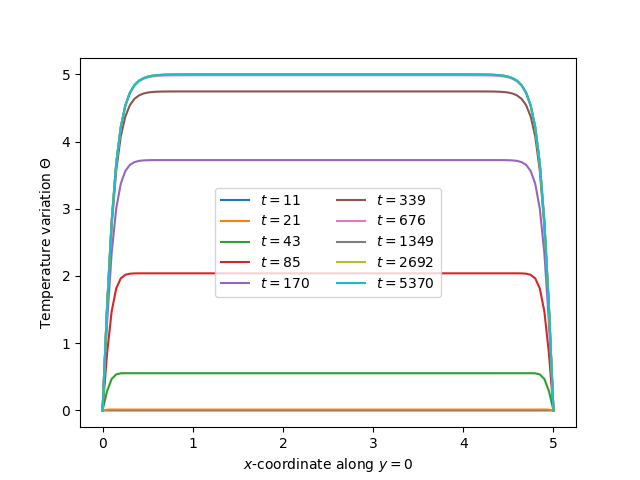

In [12]:
Nincr = 100
t = np.logspace(1, 4, Nincr+1)
Nx = 100
x = np.linspace(0, L, Nx)
T_res = np.zeros((Nx, Nincr+1))
U = Function(V)
for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    dt.assign(dti)
    solve(lhs(form) == rhs(form), U, bcs)
    Uold.assign(U)
    T_res[:, i+1] = [U(xi, H/2)[2] for xi in x]


plt.figure()
plt.plot(x, T_res[:, 1::Nincr//10])
plt.xlabel("$x$-coordinate along $y=0$")
plt.ylabel("Temperature variation $\Theta$")
plt.legend(["$t={:.0f}$".format(ti) for ti in t[1::Nincr//10]], ncol=2)
plt.show()